# Ordinary Differential Equations

### General Form: $\frac{dx_i(t)}{dt} = f_i(t, x_1,\dots x_N)$

* FIRST ORDER:
    * Euler
    * Euler-Cromer
    * Predictor-Corrector
    * RK4
    * Runge-Kutta (Two Stage - Second Order)
        * Heum's Method
        * Mid-Point Method
        * Ralston's Method


* SECOND ORDER:
    * Verlet
    * Leapfrog

### NOTES:

* If $f$ is independent of $x$, the system is *time-invariant* and is also known as *Autonomous System*. In these cases, the function definition for $f$ can be simplified to not pass $x_i$ as a parameter.

* *Global Error* refers to total accumulated error, while *Local Error* refers to error/deviance from exact solution, per time-step.

### IMPROVEMENTS:

* All Second-Order Two-Stage RK Methods can be combined into a single function, based on the $\alpha-$parameterization.

In [1]:
# Basic Imports
import numpy as np, scipy as sc, matplotlib.pyplot as plt

## Euler Method

Using Taylor Series and Fundamental Theorem of Calculus, we get:

$$\boxed{x_{i+1} = x_i + \Delta tf(t_i, x_i) + \mathcal{O}(\Delta t^2)}$$

$$\boxed{t_{i+1} = t_i + \Delta t}$$

### Notes:

* Uses Forward Difference Approximation to First Derivative
* First-Order Integrator $\implies$ Global Error = $\mathcal{O}(\Delta t)$ | Local Error =  $\mathcal{O}(\Delta t^2)$.
* Higher order equations need to be (and can always be) broken down into (coupled) first order equations and solved simultaneously

* NOT Symplectic: Often, the energy increases steadily when the standard Euler method is applied, making it far less accurate.

* Only Consistent First Order RK, with $c_1 = 0$ and $b_1 = 1$. Check the section on RK to learn more.

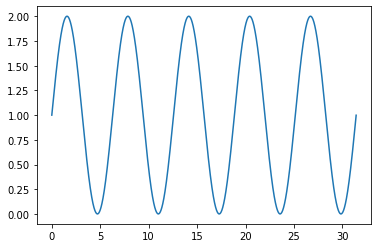

In [2]:
import numpy as np, scipy as sc, matplotlib.pyplot as plt

def euler_solver(f, x0, t0, tn, dt=1e-3):
    """
    INPUT:
    x0: Initial Condition | Value of x, at t = t0
    t0: Start Time
    tn: End Time
    dt: Time Step Size | Default = 1e-3
    f: Function, on RHS of the ODE
    OUTPUT:
    t: numpy array | Timestamps, for which the system was solved
    x: numpy array | The function to be solved for
    """
    N = int(np.ceil((tn - t0)/dt))
     
    x = np.zeros(N, dtype=float)
    t = np.zeros_like(x, dtype=float)
    # Or, define t = np.linspace(t0, tn, N, dtype=float) # Remove t[i+1] from loop then.
    
    # Initial Conditions
    x[0] = x0

    for i in range(N-1):
        x[i+1] = x[i] + dt*f(t[i], x[i])
        t[i+1] = t[i] + dt
    
    return t, x
     
# MODULE TEST
f = lambda t, x: np.cos(t)
x0 = 1
t0 = 0
tn = 10*np.pi
dt = 0.001

t, x = euler_solver(f, x0, t0, tn, dt)
plt.plot(t, x)

## Euler-Cromer Method | Semi-Implicit Euler | Symplectic Euler | Newton-Stormer-Verlet (NSV)
**SOLVING**:

$$\frac{d^2x}{dt^2} = f_v(t, x) = -k^2x$$
Where $k^2 = \frac{g}{l}$.

**BREAK UP**:

$$\frac{dx}{dt} = f_x(t, v) = v$$

$$\frac{dv}{dt} = f_v(t, x) = -k^2x$$


**DISCRETIZATION**:

$$\boxed{v_{i+1} = v_i + \Delta tf_v(t_i, v_i) + \mathcal{O}(\Delta t^2)}$$

$$\boxed{x_{i+1} = x_i + \Delta tf_x(t_i, v_i) + \mathcal{O}(\Delta t^2)}$$

The subscripts ($v$ and $x$, in $f_v$ and $f_x$) do not denote partial differentiation.

### Notes:

* First-Order Integrator $\implies$ Global Error = $\mathcal{O}(\Delta t)$ | Local Error =  $\mathcal{O}(\Delta t^2)$.

* Symplectic Integrator $\implies$ It almost conserves the energy (when the Hamiltonian is time-independent) $\implies$ Used in solving Hamilton's EoM.

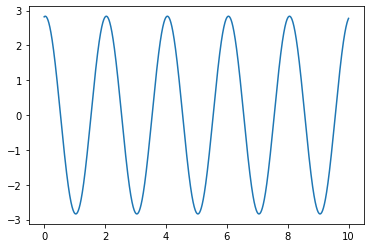

In [3]:
import numpy as np, scipy as sc, matplotlib.pyplot as plt

def eul_crom_solver(f_x, f_v, x0, v0, t0, tn, dt=1e-3):
    """
    INPUT:
    f_x: Function, on RHS of the first order ODE for x
    f_v: Function, on RHS of the first order ODE for v
    x0: Initial Condition | Value of x, at t = t0
    v0: Initial Condition/Velocity | Value of dx/dt, at t = t0
    t0: Start Time
    tn: End Time
    dt: Time Step Size | Default = 1e-3
    OUTPUT:
    t: numpy array | Timestamps, for which the system was solved
    x: numpy array | The function to be solved for
    """
    N = int(np.ceil((tn - t0)/dt))
     
    x = np.zeros(N, dtype=float)
    v = np.zeros(N, dtype=float)
    t = np.linspace(t0, tn, N, dtype=float)
    
    # Initial Conditions
    x[0] = x0
    v[0] = v0

    for i in range(N-1):
        v[i+1] = v[i] + dt*f_v(t[i], x[i])
        x[i+1] = x[i] + dt*f_x(t[i], v[i+1])
    
    return t, x
     
# MODULE TEST
l = 1 # Length of the Pendulum
g = 9.81 # Accelaration due to Gravity
k = np.sqrt(g/l)
f_x = lambda t, v: v
# f_x = lambda t, x: FUNC DEF
f_v = lambda t, x: -(k**2) * x # dv/dt = -k^2 t (With Approximation)
# f_v = lambda t, x: -(k**2) * np.sin(x) # dv/dt = -k^2 sin(t) (Without Approximation)
x0 = 2.822
v0 = 1
t0 = 0
tn = 10
dt = 0.001

t, x = eul_crom_solver(f_x, f_v, x0, v0, t0, tn, dt)
plt.plot(t, x)

## Verlet Integration Method

**SOLVING**:

$$\ddot{x}(t) = A(x(t)),$$

with initial conditions: $x(t_0) =  x_0$ and $\dot{x}(t_0) = v_0$.

* Here, $A(x(t))$ is practically "accelaration" (actually, it's a function, whose solutions give us accelaration values - can differ (a little) from exact accelaration values, depending on discrtization used - central diff, forward diff, leapfrog et cetera).

**BREAK UP**: NONE NEEDED


**DISCRETIZATION**: (Basic Stormer Equation)

$$\text{Set:  } \boxed{x_1 = x_0 + v_0\Delta t + \frac{1}{2}A(x_0)\Delta t^2 + \mathcal{O}(\Delta t^3)}$$

$$\text{For i = 1, 2...: }\boxed{x_{i+1} = 2x_i - x_{i-1} + A(x_i)\Delta t^2 + \mathcal{O}(\Delta t^4)}$$

### Notes:

* Uses Central Difference Approximation to the Second Derivative.

* Global Error: $\mathcal{O}(\Delta t^2)$ | Local Error: $\mathcal{O}(\Delta t^4)$ | Global error in velocity: $\mathcal{O}(\Delta t^2)$

* When velocities are explicitly calculated, the method is called Stormer-Verlet (which is also an equivalent representation of "Leapfrog Method"):

$$v(t) = v_i = \frac{x(t + \Delta t) - x(t - \Delta t)}{2\Delta t} + \mathcal{O}(\Delta t^2) = \frac{x_{i+1} - x_{i-1}}{2\Delta t} + \mathcal{O}(\Delta t^2)$$

* Used to solve Newton's Equation of Motion.


## SIDENOTES:

* Velocity Verlet

$$x_{i+1} = x_i + v_i\Delta t + \frac{1}
{2}a_i\Delta t^2$$

Derive $a_{i+1} = a(t_i + \Delta t)$, from the interaction potential, using $x_{i+1} = x(t_i+\Delta t)$. Then, update velocity:

$$v_{i+1} = v_i + \frac{a_i + a_{i+1}}{2}\Delta t$$

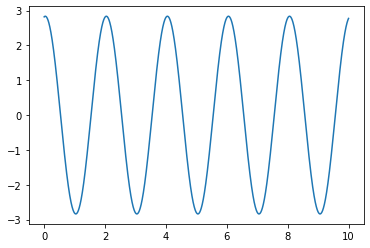

In [4]:
import numpy as np, scipy as sc, matplotlib.pyplot as plt

def verlet_solver(A, x0, v0, t0, tn, dt=1e-3):
    """
    INPUT:
    A: "Accelaration" | Function, on RHS of the original ODE
    x0: Initial Condition | Value of x, at t = t0
    v0: Initial Condition/Velocity | Value of dx/dt, at t = t0
    t0: Start Time
    tn: End Time
    dt: Time Step Size | Default = 1e-3
    OUTPUT:
    t: numpy array | Timestamps, for which the system was solved
    x: numpy array | The function to be solved for
    """
    N = int(np.ceil((tn - t0)/dt))
     
    x = np.zeros(N, dtype=float)
    t = np.linspace(t0, tn, N, dtype=float)
    
    # Initial Conditions
    x[0] = x0
    x[1] = x[0] + v0*dt + 0.5*A(x0)*dt**2

    for i in range(1, N-1):
        x[i+1] = 2*x[i] - x[i-1] + A(x[i])*dt**2
    
    return t, x
     
# MODULE TEST
l = 1 # Length of the Pendulum
g = 9.81 # Accelaration due to Gravity
k = np.sqrt(g/l)
A = lambda x: -(k**2) * x # d2x/dt2 = A(x(t)) = -k^2 t (With Approximation)
# A = lambda t, x: -(k**2) * np.sin(x) # dv/dt = -k^2 sin(t) (Without Approximation)
x0 = 2.82
v0 = 1
t0 = 0
tn = 10
dt = 0.001

t, x = verlet_solver(A, x0, v0, t0, tn, dt)
plt.plot(t, x)

## Predictor-Corrector Method

**SOLVING**:

$$\dot{x} = f(t, x), \quad x(t_0) = x_0$$

**BREAKUP**: NONE NEEDED

**DISCRETIZATION** (PREDICT-EVALUATE-CORRECT-EVALUATE OR P(EC)E SCHEME):

* Prediction Step (Euler Method):

$$\boxed{\overline{x}_{i+1} = x_i + \Delta tf(t_i, x_i)}$$

* Correction Step (Trapezoidal Rule (of Integration)):

$$\boxed{x_{i+1} = x_i + \frac{1}{2}\Delta t(f(t_i, x_i) + f(t_{i+1}, \overline{x}_{i+1}))}$$


### Notes:

* Semi-Implicit

* Second Order (Depends on the Predictor and Corrector Algorithms) $\implies$ Local Error $= \mathcal{O}(\Delta t^3)$ | Global Error $= \mathcal{O}(\Delta t^2)$.

* Similar to RK

* The General (Implicit) form is not very useful, as the system cannot be solved without an initial guess, most of the time. The General form is given below:

$$x_{i+1} = x_i + \frac{1}{2}\Delta t(f(t_i, x_i) + f(t_{i+1}, x_{i+1}))$$

* Accuracy and Stability properties are identical to those of RK.

* The Predictor and Corrector steps can be modified to better suit the problems. For example, the Predictor can be much better modifications of Euler Method, while the Corrector can be of some standard forms, such as Adams-Moulton Method.

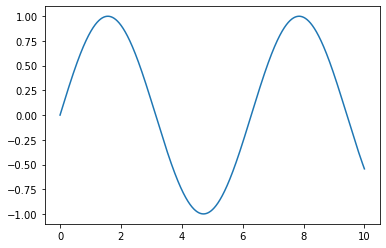

In [5]:
import numpy as np, scipy as sc, matplotlib.pyplot as plt

def pece_solver(f, x0, t0, tn, dt=1e-3):
    """
    INPUT:
    f: Function, on RHS of the First-Order ODE
    x0: Initial Condition | Value of x, at t = t0
    t0: Start Time
    tn: End Time
    dt: Time Step Size | Default = 1e-3
    OUTPUT:
    t: numpy array | Timestamps, for which the system was solved
    x: numpy array | The function to be solved for
    """
    N = int(np.ceil((tn - t0)/dt))
     
    x = np.zeros(N, dtype=float)
    t = np.linspace(t0, tn, N, dtype=float)
    
    # Initial Conditions
    x[0] = x0

    for i in range(N-1):
        # Prediciton Step
        x[i+1] = x[i] + dt*f(t[i], x[i])
        # Correction Step - Self-Reference is safe here, because, in Python, RHS of assignment expressions is evaluated first
        x[i+1] = x[i] + 0.5*dt*(f(t[i], x[i]) + f(t[i+1], x[i+1]))
    
    return t, x
     
# MODULE TEST
f = lambda t, x: np.cos(t)
x0 = 0
t0 = 0
tn = 10
dt = 0.001

t, x = pece_solver(f, x0, t0, tn, dt)
plt.plot(t, x)

## RK4 | Classic Runge-Kutta

**SOLVING**:

$$\dot{x} = f(t, x), \quad x(t_0) = x_0$$

**BREAKUP**: NONE NEEDED

**DISCRETIZATION**:

$$\boxed{x_{i+1} = x_i + \frac{\Delta t}{6}(k_1 + 2k_2 + 2k_3 + k_4)}$$

$$\boxed{t_{i+1} = t_i + \Delta t},$$

Using:

$$k_1 = f(t_i, x_i)$$

$$k_2 = f\left(t_i + \frac{\Delta t}{2}, x_i + \frac{k_1}{2}\right)$$

$$k_3 = f\left(t_i + \frac{\Delta t}{2}, x_i + \frac{k_2}{2}\right)$$

$$k_4 = f(t_i + \Delta t, x_i + k_3)$$


### Notes:

* Used for First-Order ODEs | Improvement over Euler's Method.

* Fourth-Order Method $\implies$ Local Error: $\mathcal{O}(\Delta t^5)$ | Global Error: $\mathcal{O}(\Delta t^4)$

* Weighted average of 4 increments, with greater weight to increments, at midpoint:
    * $k_1$ - Slope at beginning of interval (Euler)
    * $k_2$ - Slope at midpoint of interval, using $x$ and $k_1$
    * $k_3$ - Slope at midpoint, using $x$ and $k_2$
    * $k_4$ - Slope at end of interval, using $x$ and $k_3$
   
   
* Above point also implies: If $f$ is independent of $x$ or the ODE is equivalent to a simple integral, then RK4 is equivalent to *Simpson's Rule* (Open - 1,4,1).

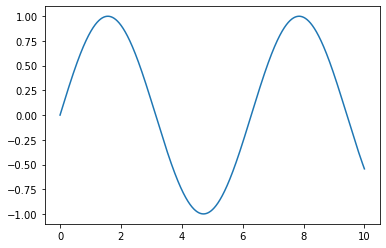

In [6]:
import numpy as np, scipy as sc, matplotlib.pyplot as plt

def rk4_solver(f, x0, t0, tn, dt=1e-3):
    """
    INPUT:
    f: Function, on RHS of the First-Order ODE
    x0: Initial Condition | Value of x, at t = t0
    t0: Start Time
    tn: End Time
    dt: Time Step Size | Default = 1e-3
    OUTPUT:
    t: numpy array | Timestamps, for which the system was solved
    x: numpy array | The function to be solved for
    """
    N = int(np.ceil((tn - t0)/dt))
     
    x = np.zeros(N, dtype=float)
    t = np.linspace(t0, tn, N, dtype=float)
    
    # Initial Conditions
    x[0] = x0

    for i in range(N-1):
        k1 = f(t[i], x[i])
        k2 = f(t[i] + 0.5*dt, x[i] + 0.5*dt*k1)
        k3 = f(t[i] + 0.5*dt, x[i] + 0.5*dt*k2)
        k4 = f(t[i]+dt, x[i]+k3)
        x[i+1] = x[i] + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)
    
    return t, x
     
# MODULE TEST
f = lambda t, x: np.cos(t)
x0 = 0
t0 = 0
tn = 10
dt = 0.001

t, x = rk4_solver(f, x0, t0, tn, dt)
plt.plot(t, x)

## Explicit Runge-Kutta (Family of) Methods

#### REFERENCE: https://en.wikipedia.org/wiki/List_of_Runge–Kutta_methods

**GIVEN AS**:

$$\boxed{x_{i+1} = x_i + \Delta t\sum_{i = 1}^s b_ik_i}$$
where:

$$k_1 = f(t_i, x_i)$$

$$k_2 = f(t_i + c_2\Delta t, x_i + \Delta t(a_{21}k_1))$$

$$k_3 = f(t_i + c_3\Delta t, x_i + \Delta t(a_{31}k_1 + a_{32}k_2))$$

$$\boxed{k_s = f(t_i + c_s\Delta t, x_i + \Delta t(a_{s1}k_1 + a_{s2}k_2 + \dots + a_{s, s-1}k_{s-1}))}$$

* $\boxed{t_{i+1} = t_i + \Delta t}$
* $s$ is an Integer, specifying the number of stages.

* $[a_{i,j}]$ (for $1 \le j \lt i \le s$) form the Runge-Kutta Matrix, while $b_i$ (for $i = 1, 2,\dots$) and $c_i$ (for $i = 2, 3,\dots$) are known as the *weights* and *nodes*, respectively.

* $s$, $a_{i,j}$, $b_i$ and $c_i$ must be specified beforehand. These can be arranged in a mnemonic device, known as a *Butcher Tableau*, as given below:

    * General (The matrix is triangular, if RK procedure used is EXPLICIT. If IMPLICIT, then NOT triangular) Butcher Tableau
    
    ![General Butcher Tableau](https://rotordynamics.files.wordpress.com/2014/04/new-picture-28.png)

    * Butcher Tableau for RK4:
    
    ![For RK4](https://rotordynamics.files.wordpress.com/2014/04/new-picture-35.png)
    
* Consistency Condition for General RK: $$\sum_{j = 1}^{i-1}a_{ij} = c_i\quad\text{(for $i = 2, 3,\dots$)}$$

* Order $= p \implies$ Local (truncation) error $= \mathcal{O}(\Delta t^{p+1})$ | Global error $= \mathcal{O}(\Delta t^p)$ (Usually)

* Using the consistency condition, one can calculate the coefficients for any specific order (may not be easy for higher order). For example, for Order, $p = 2$: $b_1 + b_2 = 1$, $b_2c_2 = \frac{1}{2}$, and $a_{21} = c_2$.

### Notes:

* Generalization of the Classic RK4

* Some choices of coefficients (Butcher Tableau) are given below:
    * RK 3/8:
        * $a_{i,j} = 1/3 | -\!1/3, 1 | 1, -1, 1$ (Considering only NON-ZERO rows, starting from Row 2)
        * $c_i = (0, 1/3, 2/3, 1)$
        * $b_i = (1/8, 3/8, 3/8, 1/8)$
    * Second-Order Two-Stage RK is parameterized by $\alpha$ and the corresponding Butcher Tableau is:
        * $a_{2,1} = \alpha$ (ONLY 1 NON-ZERO ROW)
        * $c_i = (0, \alpha)$
        * $b_i = (1 - 1/(2\alpha), 1/(2\alpha))$ 
    * Mid-Point Method ($\alpha = 1/2$):
        * $a_{2,1} = 1/2$ (Only 2 rows, WITH 1 NON-ZERO ROW, because Order, $p = 1$)
        * $c_i = (0, 1/2)$
        * $b_i = (0, 1)$
    * Heun's Method ($\alpha = 1$):
        * $a_{2,1} = 1$ (Only 2 rows, WITH 1 NON-ZERO ROW, because Order, $p = 1$)
        * $c_i = (0, 1)$
        * $b_i = (1/2, 1/2)$
    * Ralston's Method ($\alpha = 2/3$):
        * $a_{2,1} = 2/3$ (Only 2 rows, WITH 1 NON-ZERO ROW, because Order, $p = 1$)
        * $c_i = (0, 2/3)$
        * $b_i = (1/4, 3/4)$


### Mid-Point Method

From above, we get:

$$\boxed{x_{i+1} = x_i + \Delta tf\left(t_i + \frac{\Delta t}{2}, x_i + \frac{\Delta t}{2}f(t_i, x_i)\right)}$$

Or, using the Tableau ($\alpha = 1/2$):

$$x_{i+1} = x_i + \Delta t\left(0\times k_1 + 1\times k_2\right) = x_i + \Delta tk_2$$

where:

$$k_1 = f(t_i, x_i)$$

$$k_2 = f(t_i + (1/2)\times\Delta t, x_i + (1/2)\times\Delta tf(t_i, x_i)) = f\left(t_i + \frac{\Delta t}{2}, x_i + \frac{\Delta t}{2}k_1\right)$$

#### Notes:

* Second Order Method $\implies$ Local Error $= \mathcal{O}(\Delta t^3)$ | Global Error $= \mathcal{O}(\Delta t^2)$.

* Consider the following figure. The diagram illustrates that the tangent at the midpoint (upper, green line segment) would most likely give a more accurate approximation of the curve in that interval. This tangent is estimated by using the original Euler's method to estimate the value of $x(t)$ at the midpoint, then computing the slope of the tangent with $f()$. Finally, the improved tangent is used to calculate the value of $x_{i+1}$ from $x_{i}$. This last step is represented by the red chord in the diagram. Note that the red chord is not exactly parallel to the green segment (the true tangent), due to the error in estimating the value of $x(t)$ at the midpoint.

<img src="https://upload.wikimedia.org/wikipedia/commons/3/39/Midpoint_method_illustration.png" width="400" title="Heun's Method Visualization"/>

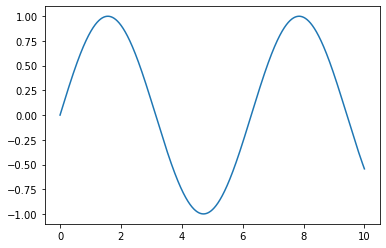

In [7]:
import numpy as np, scipy as sc, matplotlib.pyplot as plt

def rk2_mid_solver(f, x0, t0, tn, dt=1e-3):
    """
    INPUT:
    f: Function, on RHS of the First-Order ODE
    x0: Initial Condition | Value of x, at t = t0
    t0: Start Time
    tn: End Time
    dt: Time Step Size | Default = 1e-3
    OUTPUT:
    t: numpy array | Timestamps, for which the system was solved
    x: numpy array | The function to be solved for
    """
    N = int(np.ceil((tn - t0)/dt))
     
    x = np.zeros(N, dtype=float)
    t = np.linspace(t0, tn, N, dtype=float)
    
    # Initial Conditions
    x[0] = x0

    for i in range(N-1):
        k1 = f(t[i], x[i])
        k2 = f(t[i] + 0.5*dt, x[i] + 0.5*dt*k1)
        x[i+1] = x[i] + dt*k2
    
    return t, x
     
# MODULE TEST
f = lambda t, x: np.cos(t)
x0 = 0
t0 = 0
tn = 10
dt = 0.001

t, x = rk2_mid_solver(f, x0, t0, tn, dt)
plt.plot(t, x)

### Heun's Method

From above, we get:

$$\boxed{x_{i+1} = x_i + \frac{\Delta t}{2}(f(t_i, x_i) +  f(t_i + \Delta t, x_i + \Delta tf(t_i, x_i)))}$$

Or, using the Tableau ($\alpha = 1$):

$$x_{i+1} = x_i + \Delta t\left((1/2)\times k_1 + (1/2)\times k_2\right) = x_i + \frac{\Delta t}{2}(k_1 + k_2)$$

where:

$$k_1 = f(t_i, x_i)$$

$$k_2 = f(t_i + 1\times\Delta t, x_i + 1\times\Delta tf(t_i, x_i)) = f\left(t_i + \Delta t, x_i + \Delta tk_1\right)$$


#### Notes:

* Second Order Method $\implies$ Local Error $= \mathcal{O}(\Delta t^3)$ | Global Error $= \mathcal{O}(\Delta t^2)$.

* Based on, improves upon and extends Euler's Method into a Two-Stage Second-Order RK Method.

* Heun's Method considers the tangent lines to the solution curve at both ends of the interval, one which overestimates, and one which underestimates the ideal vertical coordinates. A prediction line must be constructed based on the right end point tangent's slope alone, approximated using Euler's Method. If this slope is passed through the left end point of the interval, the result is evidently too steep to be used as an ideal prediction line and overestimates the ideal point. Therefore, the ideal point lies approximately halfway between the erroneous overestimation and underestimation, the average of the two slopes. Check the figure below:
<img src="https://upload.wikimedia.org/wikipedia/commons/5/52/Heun%27s_Method_Diagram.jpg" width="400" title="Heun's Method Visualization"/>

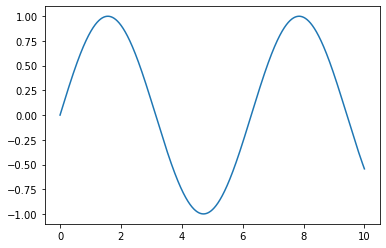

In [8]:
import numpy as np, scipy as sc, matplotlib.pyplot as plt

def rk2_heun_solver(f, x0, t0, tn, dt=1e-3):
    """
    INPUT:
    f: Function, on RHS of the First-Order ODE
    x0: Initial Condition | Value of x, at t = t0
    t0: Start Time
    tn: End Time
    dt: Time Step Size | Default = 1e-3
    OUTPUT:
    t: numpy array | Timestamps, for which the system was solved
    x: numpy array | The function to be solved for
    """
    N = int(np.ceil((tn - t0)/dt))
     
    x = np.zeros(N, dtype=float)
    t = np.linspace(t0, tn, N, dtype=float)
    
    # Initial Conditions
    x[0] = x0

    for i in range(N-1):
        k1 = f(t[i], x[i])
        k2 = f(t[i] + dt, x[i] + dt*k1)
        x[i+1] = x[i] + (dt/2)*(k1 + k2)
    
    return t, x
     
# MODULE TEST
f = lambda t, x: np.cos(t)
x0 = 0
t0 = 0
tn = 10
dt = 0.001

t, x = rk2_heun_solver(f, x0, t0, tn, dt)
plt.plot(t, x)

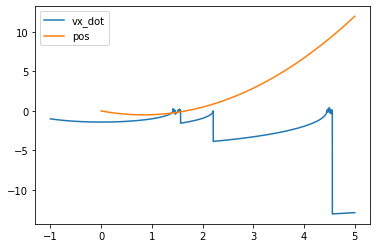

In [16]:
import numpy as np, scipy as sc, matplotlib.pyplot as plt

def rk2_heun_solver(f, x0, t0, tn, dt=1e-3):
    """
    INPUT:
    f: Function, on RHS of the First-Order ODE
    x0: Initial Condition | Value of x, at t = t0
    t0: Start Time
    tn: End Time
    dt: Time Step Size | Default = 1e-3
    OUTPUT:
    t: numpy array | Timestamps, for which the system was solved
    x: numpy array | The function to be solved for
    """
    N = int(np.ceil((tn - t0)/dt))
     
    x = np.zeros(N, dtype=float)
    t = np.linspace(t0, tn, N, dtype=float)
    
    # Initial Conditions
    x[0] = x0

    for i in range(N-1):
        k1 = f(t[i], x[i])
        k2 = f(t[i] + dt, x[i] + dt*k1)
        x[i+1] = x[i] + (dt/2)*(k1 + k2)
    
    return N, t, x
     
# MODULE TEST
f = lambda vx, vx_dot: -(vx/vx_dot)
vx0 = -1
vx_dot0 = -1 # = vy
vxn = 5
dt = 0.001

t0, tn = 0, 5

# N = int(np.ceil((tn - t0)/dt))
# t = np.linspace(t0, tn, N, dtype=float)

N, vx, vx_dot = rk2_heun_solver(f, vx_dot0, vx0, vxn, dt)
plt.plot(vx, vx_dot, label="vx_dot")


def eul_crom_solver(f_x, f_v, x0, v0, t0, N, dt=1e-3):
    """
    INPUT:
    f_x: Function, on RHS of the first order ODE for x
    f_v: Function, on RHS of the first order ODE for v
    x0: Initial Condition | Value of x, at t = t0
    v0: Initial Condition/Velocity | Value of dx/dt, at t = t0
    t0: Start Time
    N: NUMBER OF SLICES
    dt: Time Step Size | Default = 1e-3
    OUTPUT:
    t: numpy array | Timestamps, for which the system was solved
    x: numpy array | The function to be solved for
    """
#     N = int(np.ceil((tn - t0)/dt))
     
    x = np.zeros(N, dtype=float)
    v = np.zeros(N, dtype=float)
    t = np.linspace(t0, tn, N, dtype=float)
    
    # Initial Conditions
    x[0] = x0
    v[0] = v0

    for i in range(N-1):
        v[i+1] = v[i] + dt*f_v[i]
        x[i+1] = x[i] + dt*f_x[i+1]
    
    return t, x


f_v = vx_dot
f_x = vx
x0 = 0
v0 = 1
t0 = 0
N = N
dt = dt


t, x = eul_crom_solver(f_x, f_v, x0, v0, t0, N, dt)

plt.plot(t, x, label="pos")
plt.legend()

### Ralston's Method

From above, we get:

$$\boxed{x_{i+1} = x_i + \frac{\Delta t}{4}\left(f(t_i, x_i) + 3f\left(t_i + \frac{2}{3}\Delta t, x_i + \frac{2}{3}\Delta tf(t_i, x_i)\right)\right)}$$

Or, using the Tableau ($\alpha = 2/3$):

$$x_{i+1} = x_i + \Delta t\left((1/4)\times k_1 + (3/4)\times k_2\right) = x_i + \frac{\Delta t}{4}(k_1 + 3k_2)$$

where:

$$k_1 = f(t_i, x_i)$$

$$k_2 = f(t_i + (2/3)\times\Delta t, x_i + (2/3)\times\Delta tf(t_i, x_i)) = f\left(t_i + \frac{2}{3}\Delta t, x_i + \frac{2}{3}\Delta t k_1\right)$$

#### Notes:

* Second Order Two-Stage RK Procedure

* Second Order Method $\implies$ Local Error $= \mathcal{O}(\Delta t^3)$ | Global Error $= \mathcal{O}(\Delta t^2)$.

* Variant of Heun's Method

* Richardson Extrapolation can be used for this process.

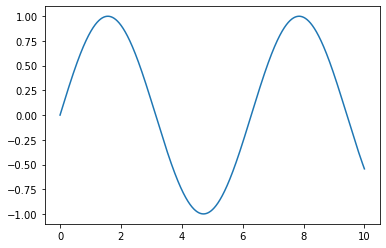

In [9]:
import numpy as np, scipy as sc, matplotlib.pyplot as plt

def rk2_rals_solver(f, x0, t0, tn, dt=1e-3):
    """
    INPUT:
    f: Function, on RHS of the First-Order ODE
    x0: Initial Condition | Value of x, at t = t0
    t0: Start Time
    tn: End Time
    dt: Time Step Size | Default = 1e-3
    OUTPUT:
    t: numpy array | Timestamps, for which the system was solved
    x: numpy array | The function to be solved for
    """
    N = int(np.ceil((tn - t0)/dt))
     
    x = np.zeros(N, dtype=float)
    t = np.linspace(t0, tn, N, dtype=float)
    
    # Initial Conditions
    x[0] = x0

    for i in range(N-1):
        k1 = f(t[i], x[i])
        k2 = f(t[i] + (2/3)*dt, x[i] + (2/3)*dt*k1)
        x[i+1] = x[i] + (dt/4)*(k1 + 3*k2)
    
    return t, x
     
# MODULE TEST
f = lambda t, x: np.cos(t)
x0 = 0
t0 = 0
tn = 10
dt = 0.001

t, x = rk2_rals_solver(f, x0, t0, tn, dt)

plt.plot(t, x)

## Leapfrog Method

![Leapfrog Visualization](https://www.physics.drexel.edu/students/courses/Comp_Phys/Integrators/leapfrog/leapfrog.gif)

**SOLVING**:

$$\ddot{x} = \frac{d^2x}{dt^2} = F(x) = a(x),$$

with $x(t_0) = x_0$ and $\dot{x}(t_0) = v(t_0) = v_0$

**BREAKUP**:

$$\frac{dv}{dt} = \dot{v} = a(x, v) = a(x), \quad \dot{x} = \frac{dx}{dt} = v$$

**DISCRETIZATION**:

$$\text{Set:  } \boxed{v_{\frac{1}{2}} = v_0 + a_0\frac{dt}{2}}$$
Here, $a_i = a(x_i)$ (in code, $a = A$).

$$\boxed{x_{i} = x_{i-1} + v_{i-\frac{1}{2}}\Delta t}$$

$$\boxed{v_{i+\frac{1}{2}} = v_{i-\frac{1}{2}} + a_{i}\Delta t}$$

* Accelerations, $a_i$, are defined only at integer $t_i$, like positions, $x_i$ (made clear by position-only-dependence/velocity-independence of $a$).

* Velocities, $v$ are defined only at half-integer $t_i$

### Notes:

* Time-Reversible + EXACTLY Symplectic $\implies$ can be used in Hamiltonian Monte Carlo (a method for drawing random samples, from a probability distribution, whose overall normalization is unknown).

* Time-Reversibility is due to cancellation of error terms (highly dependent on the constancy of $\Delta t$).

* Similar to Velocity Verlet | Formally equivalent to Mid-Point or Second Order Predictor-Corrector Method.

* Second Order Method | Yet, requires the same number of functional evaluations, as Euler.

* Unlike Euler, this method is stable for oscillatory motion (as long as $\Delta t$ is constant and $\Delta t \le \frac{2}{\omega}$).

* Used to solve dynamical systems (Classical Mechanics)

* Using Yoshida coefficients, applying the leapfrog integrator multiple times, with the correct timesteps, a much higher order integrator can be generated.

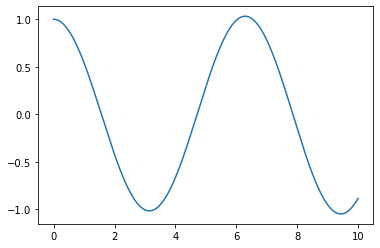

In [10]:
import numpy as np, scipy as sc, matplotlib.pyplot as plt

def leapfrog_solver(A, x0, v0, t0, tn, dt=1e-3):
    """
    INPUT:
    A: "Accelaration" | Function, on RHS of the original ODE
    x0: Initial Condition | Value of x, at t = t0
    v0: Initial Condition/Velocity | Value of dx/dt, at t = t0
    t0: Start Time
    tn: End Time
    dt: Time Step Size | Default = 1e-3
    OUTPUT:
    t: numpy array | Timestamps, for which the system was solved
    x: numpy array | The function to be solved for
    """
    N = int(np.ceil((tn - t0)/dt))
     
    x = np.zeros(N, dtype=float)
    v = np.zeros(N, dtype=float)
    t = np.linspace(t0, tn, N, dtype=float)
    
    # Initial Conditions
    x[0] = x0
    v[0] = v0 + A(x[0])*(dt/2) # = v_{1/2} = v_0 + a_0(dt/2). Next step will be v_{3/2} == v[1] and so on...

    for i in range(N-1):
        x[i+1] = x[i] + v[i]*dt
        v[i+1] = v[i] + A(x[i])*dt
    
    return t, x
     
# MODULE TEST
l = 1 # Length of the Pendulum
g = 9.81 # Accelaration due to Gravity
k = np.sqrt(g/l)
A = lambda x: -(k**2) * x # d2x/dt2 = A(x(t)) = -k^2 t (With Approximation)
# A = lambda t, x: -(k**2) * np.sin(x) # dv/dt = -k^2 sin(t) (Without Approximation)
x0 = 2.822
v0 = 1
t0 = 0
tn = 10
dt = 0.001


A_1 = lambda x: -x
x0_1 = 1
v0_1 = 0
t0_1 = 0
tn_1 = 10
dt_1 = 0.01

t, x = leapfrog_solver(A_1, x0_1, v0_1, t0_1, tn_1, dt_1)
plt.plot(t, x)